### This code is a new branch where CSAT data that use is after analysis (Taking Out The Unnecessary Data)

In [15]:
import gspread
import pandas as pd
from datetime import date
from google.oauth2.service_account import Credentials

## Pipeline A

In [16]:
SERVICE_ACCOUNT_FILE = '../../key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open("Chatbot Ops Report").worksheet("[CSAT After Take Out]")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               596 non-null    object
 1   Total Good Survey  596 non-null    object
 2   Total Bad Survey   596 non-null    object
 3   Total Responden    596 non-null    object
 4   Total Rating       596 non-null    object
 5   CSAT [Before]      596 non-null    object
 6   CSAT [After]       596 non-null    object
 7   %                  596 non-null    object
 8                      596 non-null    object
 9   Date               596 non-null    object
 10  Total Good Survey  596 non-null    object
 11  Total Bad Survey   596 non-null    object
 12  Total Responden    596 non-null    object
 13  Total Rating       596 non-null    object
 14  CSAT               596 non-null    object
dtypes: object(15)
memory usage: 70.0+ KB


In [18]:
# Copying the DF
df_before = (
    df.copy()
    .iloc[:, [0,3,4,5]]
    .drop_duplicates(subset='Date')
)

df_after = (
    df.copy()
    .iloc[:, [9,12,13,6]]
    .drop_duplicates(subset='Date')
)

# Changing the Date data type
df_before['Date'] = pd.to_datetime(
    df_before['Date'], format='%d-%b-%Y', errors='coerce'
)

df_after['Date'] = pd.to_datetime(
    df_after['Date'], format='%d-%b-%Y', errors='coerce'
)

# dropping NA
df_before = df_before.dropna(subset=['Date'])
df_after = df_after.dropna(subset=['Date'])

df_before.info()

<class 'pandas.core.frame.DataFrame'>
Index: 595 entries, 0 to 595
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             595 non-null    datetime64[ns]
 1   Total Responden  595 non-null    object        
 2   Total Rating     595 non-null    object        
 3   CSAT [Before]    595 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.2+ KB


In [19]:
df_after.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 0 to 595
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             594 non-null    datetime64[ns]
 1   Total Responden  594 non-null    object        
 2   Total Rating     594 non-null    object        
 3   CSAT [After]     594 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.2+ KB


### Feature Engineering on data CSAT After Take Out

In [20]:
import matplotlib.pyplot as plt

df_merge = df_before.merge(df_after, on='Date', how='left', suffixes=('_Before', '_After'))

In [21]:
# Data Type
cols = ['Total Responden_After', 'Total Rating_After', 'CSAT [After]']
df_merge[cols] = df_merge[cols].apply(pd.to_numeric, errors='coerce')

In [22]:
# Filling NA with rolling window method
missing_mask = df_merge['CSAT [After]'].isna()

df_merge['CSAT_Imputed'] = df_merge['CSAT [After]'].fillna(
    df_merge['CSAT [After]'].rolling(window=7, min_periods=1, center=True).mean()
)

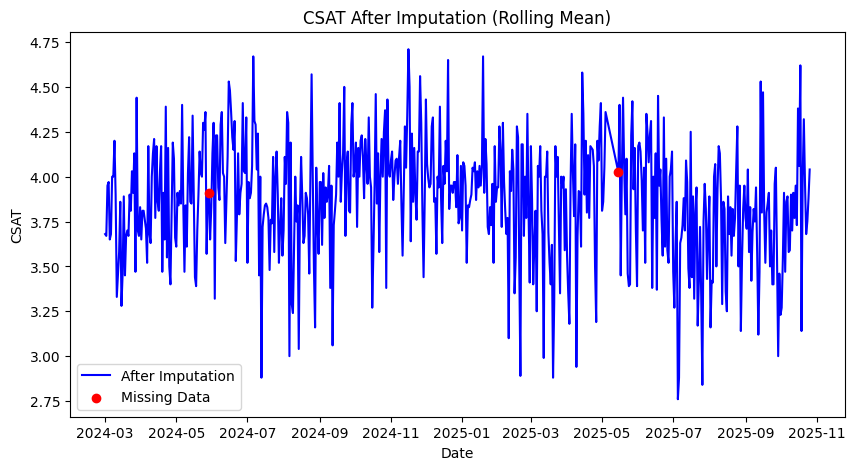

In [23]:
plt.figure(figsize=(10,5))
plt.plot(df_merge['Date'], df_merge['CSAT_Imputed'], label='After Imputation', color='blue')

plt.scatter(df_merge.loc[missing_mask, 'Date'],
            df_merge.loc[missing_mask, 'CSAT_Imputed'],
            color='red', label='Missing Data', zorder=5)

plt.title('CSAT After Imputation (Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('CSAT')
plt.legend()
plt.show()

In [24]:
# export to csv
df_before.to_csv('../../dataset_kula/csat_before_takeout.csv')
df_after.to_csv('../../dataset_kula/csat_after_takeout.csv')